58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 204s 3us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Random Forest Accuracy: 0.7307692307692307


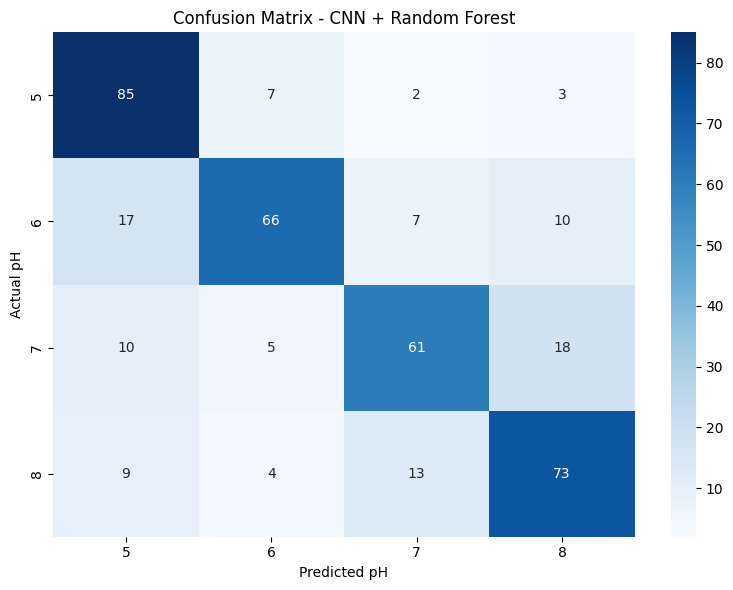

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array

# ---------------------------
# Step 1: Load Images & Labels (pH from filename)
# ---------------------------
SIZE = 128
X = []
labels = []

data_dir = "Split_Data"

for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_dir, split)
    for time_folder in os.listdir(split_path):
        time_path = os.path.join(split_path, time_folder)
        if not os.path.isdir(time_path): continue

        for condition_folder in os.listdir(time_path):
            condition_path = os.path.join(time_path, condition_folder)
            if not os.path.isdir(condition_path): continue

            for img_name in os.listdir(condition_path):
                img_path = os.path.join(condition_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                X.append(img)

                # Extract pH from filename (e.g., "cropped_0hr_pH5_W14.JPG")
                match = re.search(r'pH(\d+)', img_name)
                if match:
                    ph = int(match.group(1))
                else:
                    continue
                labels.append(ph)

X = np.array(X)
labels = np.array(labels)

# ---------------------------
# Step 2: Preprocessing
# ---------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

x_train = x_train / 255.0
x_test = x_test / 255.0

# ---------------------------
# Step 3: Feature Extraction using CNN
# ---------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
feature_model = Model(inputs=base_model.input, outputs=x)

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features
features_train = feature_model.predict(x_train, batch_size=32, verbose=1)
features_test = feature_model.predict(x_test, batch_size=32, verbose=1)

# ---------------------------
# Step 4: Train Random Forest
# ---------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, y_train)

y_pred = rf.predict(features_test)
acc = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted pH")
plt.ylabel("Actual pH")
plt.title("Confusion Matrix - CNN + Random Forest")
plt.tight_layout()
plt.show()
